# The Continuous Thought Machine – Tutorial 05: Hugging Face [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SakanaAI/continuous-thought-machines/blob/main/examples/05_huggingface.ipynb) [![arXiv](https://img.shields.io/badge/arXiv-2505.05522-b31b1b.svg)](https://arxiv.org/abs/2505.05522)

The CTM is now on Hugging Face! 🤗

Specifically, we have uploaded the image classification CTM trained on ImageNet, and the large maze solving CTM. Additionally, we have uploaded the maze datsets (in small, medium, large and extralarge variants) to make working with this task more convienient!

Everything can be found on Hugging Face [here](https://huggingface.co/collections/SakanaAI/continuous-thought-machines-68edd4bb94a7809e074468e7)!

In this notebook, we walkthough how to load both of these models, as well as how to use the maze datasets.

## Setup

If running the notebook in Colab, set `USE_COLAB` to `True` to clone the repo.

In [18]:
USE_COLAB = False

In [19]:
import sys

if USE_COLAB:
    !git clone https://github.com/SakanaAI/continuous-thought-machines.git
    sys.path.append("./continuous-thought-machines")
else:
    sys.path.append("..")

In [20]:
!pip install mediapy

In [21]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import random
from PIL import Image
from torchvision import transforms
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib import patheffects
from scipy import ndimage
import imageio
import mediapy
from torch.utils.data import DataLoader
from datasets import load_dataset

from models.ctm import ContinuousThoughtMachine as CTM
from image_classification.imagenet_classes import IMAGENET2012_CLASSES
from utils.losses import maze_loss
from tasks.mazes.plotting import make_maze_gif

In [22]:
def set_seed(seed=42, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = deterministic
    torch.backends.cudnn.benchmark = False

In [23]:
set_seed(42) # ... the meaning of life is ...

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading a Pretrained Model

To load the image classfication CTM we can simply call `from_pretrained` on the CTM class.

In [ ]:
model = CTM.from_pretrained("SakanaAI/ctm-imagenet")
model = model.to(device)
model.eval();

Using neuron select type: random-pairing
Synch representation size action: 2048
Synch representation size out: 8196


Let's test the model by running inference with it. We download an image and convert it to a PyTorch Tensor.

In [32]:
filename = "goldfish.jpg"

if os.path.exists(filename):
    print(f"Loading {filename} from local directory...")
    image = Image.open(filename).convert("RGB")
else:
    print(f"{filename} not found locally. Downloading...")
    url = "https://www.seahorseaquariums.com/image/cache/catalog/Categories%20-%20Freshewater/Coldwater%20Fish/Fantails/Fantail%20Goldfish-2000x2000.jpg"
    urllib.request.urlretrieve(url, filename)
    image = Image.open(filename).convert("RGB")
target = 1  # Goldfish
urllib.request.urlretrieve(url, filename)
image = Image.open(filename).convert("RGB")

# Preprocess the image
dataset_mean = [0.485, 0.456, 0.406]
dataset_std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

input_tensor = transform(image).unsqueeze(0).to(device)

Loading goldfish.jpg from local directory...


Run a forward pass with the CTM. For simplicity, we take the prediction at the last internal tick as the final prediction. Alternatively, we could use the prediction at the models most certain internal tick. See [tutorial 01: MNIST](https://github.com/SakanaAI/continuous-thought-machines/blob/main/examples/01_mnist.ipynb) for more details.

In [27]:
with torch.no_grad():
    predictions, certainties, synchronization, pre_activations, post_activations, attention_tracking = model(input_tensor, track=True)
# Get predictions
prediction_last = predictions[0, :, -1].argmax(dim=0)
IMAGENET_CLASS_LIST = list(IMAGENET2012_CLASSES.values())

print(f"Target Class: {target} = {IMAGENET_CLASS_LIST[target]}")
print(f"Predicted Class (final): {prediction_last.item()} = {IMAGENET_CLASS_LIST[prediction_last.item()]}")

Target Class: 1 = goldfish, Carassius auratus
Predicted Class (final): 1 = goldfish, Carassius auratus


The pretrained CTM correctly classifies the image as a goldfish! 🐠

Let's make a gif to vizualise the reasoning process.

In [33]:
def make_gif(predictions, certainties, attention_tracking, ground_truth_target, out_path, dataset_mean, dataset_std):

    def find_island_centers(array_2d, threshold):
        """
        Finds the center of mass of each island (connected component > threshold)
        in a 2D array, weighted by the array's values.
        Returns list of (y, x) centers and list of areas.
        """
        binary_image = array_2d > threshold
        labeled_image, num_labels = ndimage.label(binary_image)
        centers = []
        areas = []
        # Calculate center of mass for each labeled island (label 0 is background)
        for i in range(1, num_labels + 1):
            island_mask = (labeled_image == i)
            total_mass = np.sum(array_2d[island_mask])
            if total_mass > 0:
                # Get coordinates for this island
                y_coords, x_coords = np.mgrid[:array_2d.shape[0], :array_2d.shape[1]]
                # Calculate weighted average for center
                x_center = np.average(x_coords[island_mask], weights=array_2d[island_mask])
                y_center = np.average(y_coords[island_mask], weights=array_2d[island_mask])
                centers.append((round(y_center, 4), round(x_center, 4)))
                areas.append(np.sum(island_mask)) # Area is the count of pixels in the island
        return centers, areas

    interp_mode = 'nearest'
    figscale = 0.85

    class_labels = list(IMAGENET2012_CLASSES.values()) # Load actual class names

    # predictions: (B, Classes, Steps), attention_tracking: (Steps*B*Heads, SeqLen)
    n_steps = predictions.size(-1)

    # --- Reshape Attention ---
    # Infer feature map size from model internals (assuming B=1)
    h_feat, w_feat = model.kv_features.shape[-2:]

    n_heads = attention_tracking.shape[2] 
    # Reshape to (Steps, Heads, H_feat, W_feat) assuming B=1
    attention_tracking = attention_tracking.reshape(n_steps, n_heads, h_feat, w_feat)

    # --- Setup for Plotting ---
    step_linspace = np.linspace(0, 1, n_steps) # For step colors
    # Define color maps
    cmap_spectral = sns.color_palette("Spectral", as_cmap=True)
    cmap_attention = sns.color_palette('viridis', as_cmap=True)

    # Create output directory for this index
    index_output_dir = os.path.join(out_path, str(0))
    os.makedirs(index_output_dir, exist_ok=True)

    frames = [] # Store frames for GIF
    head_routes = {h: [] for h in range(n_heads)} # Store (y,x) path points per head
    head_routes[-1] = []
    route_colours_step = [] # Store colors for each step's path segments

    # --- Loop Through Each Step ---
    for step_i in tqdm(range(n_steps), desc="Processing steps", unit="step"):

        # --- Prepare Image for Display ---
        # Denormalize the input tensor for visualization
        data_img_tensor = input_tensor[0].cpu() # Get first item in batch, move to CPU
        mean_tensor = torch.tensor(dataset_mean).view(3, 1, 1)
        std_tensor = torch.tensor(dataset_std).view(3, 1, 1)
        data_img_denorm = data_img_tensor * std_tensor + mean_tensor
        # Permute to (H, W, C) and convert to numpy, clip to [0, 1]
        data_img_np = data_img_denorm.permute(1, 2, 0).detach().numpy()
        data_img_np = np.clip(data_img_np, 0, 1)
        img_h, img_w = data_img_np.shape[:2]

        # --- Process Attention & Certainty ---
        # Average attention over last few steps (from original code)
        start_step = max(0, step_i - 5)
        attention_now = attention_tracking[start_step : step_i + 1].mean(0) # Avg over steps -> (Heads, H_feat, W_feat)
        # Get certainties up to current step
        certainties_now = certainties[0, 1, :step_i+1].detach().cpu().numpy() # Assuming index 1 holds relevant certainty

        # --- Calculate Attention Paths (using bilinear interp) ---
        # Interpolate attention to image size using bilinear for center finding
        attention_interp_bilinear = F.interpolate(
            torch.from_numpy(attention_now).unsqueeze(0).float(), # Add batch dim, ensure float
            size=(img_h, img_w),
            mode=interp_mode,
            # align_corners=False
        ).squeeze(0) # Remove batch dim -> (Heads, H, W)

        # Normalize each head's map to [0, 1]
        # Deal with mean
        attn_mean = attention_interp_bilinear.mean(0)
        attn_mean_min = attn_mean.min()
        attn_mean_max = attn_mean.max()
        attn_mean = (attn_mean - attn_mean_min) / (attn_mean_max - attn_mean_min)
        centers, areas = find_island_centers(attn_mean.detach().cpu().numpy(), threshold=0.7)

        if centers: # If islands found
            largest_island_idx = np.argmax(areas)
            current_center = centers[largest_island_idx] # (y, x)
            head_routes[-1].append(current_center)
        elif head_routes[-1]: # If no center now, repeat last known center if history exists
            head_routes[-1].append(head_routes[-1][-1])


        attn_min = attention_interp_bilinear.view(n_heads, -1).min(dim=-1, keepdim=True)[0].unsqueeze(-1)
        attn_max = attention_interp_bilinear.view(n_heads, -1).max(dim=-1, keepdim=True)[0].unsqueeze(-1)
        attention_interp_bilinear = (attention_interp_bilinear - attn_min) / (attn_max - attn_min + 1e-6)

        # Store step color
        current_colour = list(cmap_spectral(step_linspace[step_i]))
        route_colours_step.append(current_colour)

        # Find island center for each head
        for head_i in range(n_heads):
            attn_head_np = attention_interp_bilinear[head_i].detach().cpu().numpy()
            # Keep threshold=0.7 based on original call
            centers, areas = find_island_centers(attn_head_np, threshold=0.7)

            if centers: # If islands found
                largest_island_idx = np.argmax(areas)
                current_center = centers[largest_island_idx] # (y, x)
                head_routes[head_i].append(current_center)
            elif head_routes[head_i]: # If no center now, repeat last known center if history exists
                    head_routes[head_i].append(head_routes[head_i][-1])
        
                

        # --- Plotting Setup ---
        mosaic = [['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                    ['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                    ['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                    ['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                ['head_0', 'head_0_overlay', 'head_1', 'head_1_overlay', 'head_2', 'head_2_overlay', 'head_3', 'head_3_overlay'],
                ['head_4', 'head_4_overlay', 'head_5', 'head_5_overlay','head_6', 'head_6_overlay', 'head_7', 'head_7_overlay'],
                ['head_8', 'head_8_overlay', 'head_9', 'head_9_overlay','head_10', 'head_10_overlay', 'head_11', 'head_11_overlay'],
                ['head_12', 'head_12_overlay', 'head_13', 'head_13_overlay','head_14', 'head_14_overlay', 'head_15', 'head_15_overlay'],
                ['probabilities', 'probabilities','probabilities', 'probabilities', 'certainty', 'certainty', 'certainty', 'certainty'],
                ]

        img_aspect = data_img_np.shape[0] / data_img_np.shape[1]
        aspect_ratio = (8 * figscale, 9 * figscale * img_aspect) # W, H
        fig, axes = plt.subplot_mosaic(mosaic, figsize=aspect_ratio)

        for ax in axes.values():
            ax.axis('off')

        # --- Plot Certainty ---
        ax_cert = axes['certainty']
        ax_cert.plot(np.arange(len(certainties_now)), certainties_now, 'k-', linewidth=figscale*1)
        # Add background color based on prediction correctness at each step
        for ii in range(len(certainties_now)):
            is_correct = predictions[0, :, ii].argmax(-1).item() == ground_truth_target # .item() for scalar tensor
            facecolor = 'limegreen' if is_correct else 'orchid'
            ax_cert.axvspan(ii, ii + 1, facecolor=facecolor, edgecolor=None, lw=0, alpha=0.3)
        # Mark the last point
        ax_cert.plot(len(certainties_now)-1, certainties_now[-1], 'k.', markersize=figscale*4)
        ax_cert.axis('off')
        ax_cert.set_ylim([0.05, 1.05])
        ax_cert.set_xlim([0, n_steps]) # Use n_steps for consistent x-axis limit

        # --- Plot Probabilities ---
        ax_prob = axes['probabilities']
        # Get probabilities for the current step
        ps = torch.softmax(predictions[0, :, step_i], -1).detach().cpu()
        k = 5 # Top k predictions
        topk_probs, topk_indices = torch.topk(ps, k, dim=0, largest=True)
        topk_indices = topk_indices.numpy()
        topk_probs = topk_probs.numpy()

        true_class_idx = ground_truth_target # Ground truth index

        # Determine bar colors (green if correct, blue otherwise - consistent with original)
        colours = ['g' if idx == true_class_idx else 'b' for idx in topk_indices]

        # Plot horizontal bars (inverted range for top-down display)
        ax_prob.barh(np.arange(k)[::-1], topk_probs, color=colours, alpha=1) # Use barh and inverted range
        ax_prob.set_xlim([0, 1])
        ax_prob.axis('off')

        # Add text labels for top classes
        for i, name_idx in enumerate(topk_indices):
            name = class_labels[name_idx] # Get name from index
            is_correct = name_idx == true_class_idx
            fg_color = 'darkgreen' if is_correct else 'crimson' # Text colors from original
            text_str = f'{name[:40]}' # Truncate long names
            # Position text on the left side of the horizontal bars
            ax_prob.text(
                0.01, # Small offset from left edge
                k - 1 - i, # Y-position corresponding to the bar
                text_str,
                #transform=ax_prob.transAxes, # Use data coordinates for Y
                verticalalignment='center',
                horizontalalignment='left',
                fontsize=8,
                color=fg_color,
                alpha=0.9, # Slightly more visible than 0.5
                path_effects=[
                    patheffects.Stroke(linewidth=2, foreground='white'), # Adjusted stroke
                    patheffects.Normal()
                ])


        # --- Plot Attention Heads & Overlays (using nearest interp) ---
        # Re-interpolate attention using nearest neighbor for visual plotting
        attention_interp_plot = F.interpolate(
            torch.from_numpy(attention_now).unsqueeze(0).float(),
            size=(img_h, img_w),
            mode=interp_mode, # 'nearest'
        ).squeeze(0)

        attn_mean = attention_interp_plot.mean(0)
        attn_mean_min = attn_mean.min()
        attn_mean_max = attn_mean.max()
        attn_mean = (attn_mean - attn_mean_min) / (attn_mean_max - attn_mean_min)


        # Normalize each head's map to [0, 1]
        attn_min_plot = attention_interp_plot.view(n_heads, -1).min(dim=-1, keepdim=True)[0].unsqueeze(-1)
        attn_max_plot = attention_interp_plot.view(n_heads, -1).max(dim=-1, keepdim=True)[0].unsqueeze(-1)
        attention_interp_plot = (attention_interp_plot - attn_min_plot) / (attn_max_plot - attn_min_plot + 1e-6)
        attention_interp_plot_np = attention_interp_plot.detach().cpu().numpy()
        


        


        for head_i in list(range(n_heads)) + [-1]:
            axname = f'head_{head_i}' if head_i != -1 else 'head_mean'
            if axname not in axes: continue # Skip if mosaic doesn't have this head

            ax = axes[axname]
            ax_overlay = axes[f'{axname}_overlay']

            # Plot attention heatmap
            this_attn = attention_interp_plot_np[head_i] if head_i != -1 else attn_mean
            img_to_plot = cmap_attention(this_attn)
            ax.imshow(img_to_plot)
            ax.axis('off')

            # Plot overlay: image + paths
            these_route_steps = head_routes[head_i]
            arrow_scale = 1.5 if head_i != -1 else 3

            if these_route_steps: # Only plot if path exists
                # Separate y and x coordinates
                y_coords, x_coords = zip(*these_route_steps)
                y_coords = np.array(y_coords)
                x_coords = np.array(x_coords)

                # Flip y-coordinates for correct plotting (imshow origin is top-left)
                # NOTE: Original flip seemed complex, simplifying to standard flip
                y_coords_flipped = img_h - 1 - y_coords

                # Show original image flipped vertically to match coordinate system
                ax_overlay.imshow(np.flipud(data_img_np), origin='lower')

                # Draw arrows for path segments
                    # Arrow size scaling from original
                for i in range(len(these_route_steps) - 1):
                    dx = x_coords[i+1] - x_coords[i]
                    dy = y_coords_flipped[i+1] - y_coords_flipped[i] # Use flipped y for delta

                    # Draw white background arrow (thicker)
                    ax_overlay.arrow(x_coords[i], y_coords_flipped[i], dx, dy,
                                        linewidth=1.6 * arrow_scale * 1.3,
                                        head_width=1.9 * arrow_scale * 1.3,
                                        head_length=1.4 * arrow_scale * 1.45,
                                        fc='white', ec='white', length_includes_head=True, alpha=1)
                    # Draw colored foreground arrow
                    ax_overlay.arrow(x_coords[i], y_coords_flipped[i], dx, dy,
                                        linewidth=1.6 * arrow_scale,
                                        head_width=1.9 * arrow_scale,
                                        head_length=1.4 * arrow_scale,
                                        fc=route_colours_step[i], ec=route_colours_step[i], # Use step color
                                        length_includes_head=True)

            else: # If no path yet, just show the image
                    ax_overlay.imshow(np.flipud(data_img_np), origin='lower')


            # Set limits and turn off axes for overlay
            ax_overlay.set_xlim([0, img_w - 1])
            ax_overlay.set_ylim([0, img_h - 1])
            ax_overlay.axis('off')
        

        # --- Finalize and Save Frame ---
        fig.tight_layout(pad=0.1) # Adjust spacing

        # Render the plot to a numpy array
        canvas = fig.canvas
        canvas.draw()
        image_numpy = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        image_numpy = image_numpy.reshape(*reversed(canvas.get_width_height()), 4)[:,:,:3] # Get RGB

        frames.append(image_numpy) # Add to list for GIF

        

        plt.close(fig) # Close figure to free memory

    # --- Save GIF ---
    gif_path = os.path.join(out_path, 'image_classification_prediction.gif')
    print(f"Saving GIF to {gif_path}...")
    mediapy.show_video(frames, width=400, codec="gif")
    imageio.mimsave(gif_path, frames, fps=15, loop=0) # loop=0 means infinite loop
    pass

Processing steps: 100%|██████████| 50/50 [00:40<00:00,  1.22step/s]


Saving GIF to 05_output/image_classification_prediction.gif...



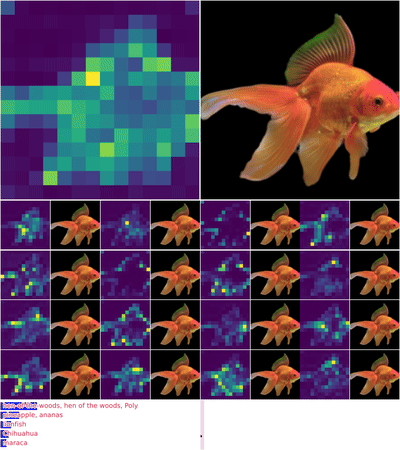

In [34]:
# Make an output folder 
out_path = "05_output"
os.makedirs(out_path, exist_ok=True)
make_gif(predictions, certainties, attention_tracking, target, out_path, dataset_mean, dataset_std);

## Maze Datasets

We will now showcase how to use the maze datasets from Hugging Face, as well as loading a pretrained maze solving CTM.

We use [Hugging Face datasets](https://huggingface.co/docs/datasets/en/index) to load the maze data.

## Dataset Structure

Each dataset contains train and test splits with the following fields:

- **`image`**: A PIL Image in RGB format representing the maze
  - **Red pixel** (255, 0, 0): Start position
  - **Green pixel** (0, 255, 0): End/goal position  
  - **Blue pixel** (0, 0, 255): Valid path (walkable areas)
  - **Black/White**: Walls and obstacles

- **`solution_path`**: A list of integers representing the sequence of moves to solve the maze
  - `0` = Move Up ↑
  - `1` = Move Down ↓
  - `2` = Move Left ←
  - `3` = Move Right →
  - `4` = Wait/Padding (used when solution is shorter than fixed length)

## Dataset Sizes

| Variant | Image Size | Solution Path Length |
|---------|------------|---------------------|
| small | 15×15 | 50 |
| medium | 19×19| 50 |
| large | 39×39 | 100 |
| extralarge | 99×99 | 100 |

When converted to tensors for training, images become shape `(3, H, W)` after applying `.permute(2, 0, 1)`.

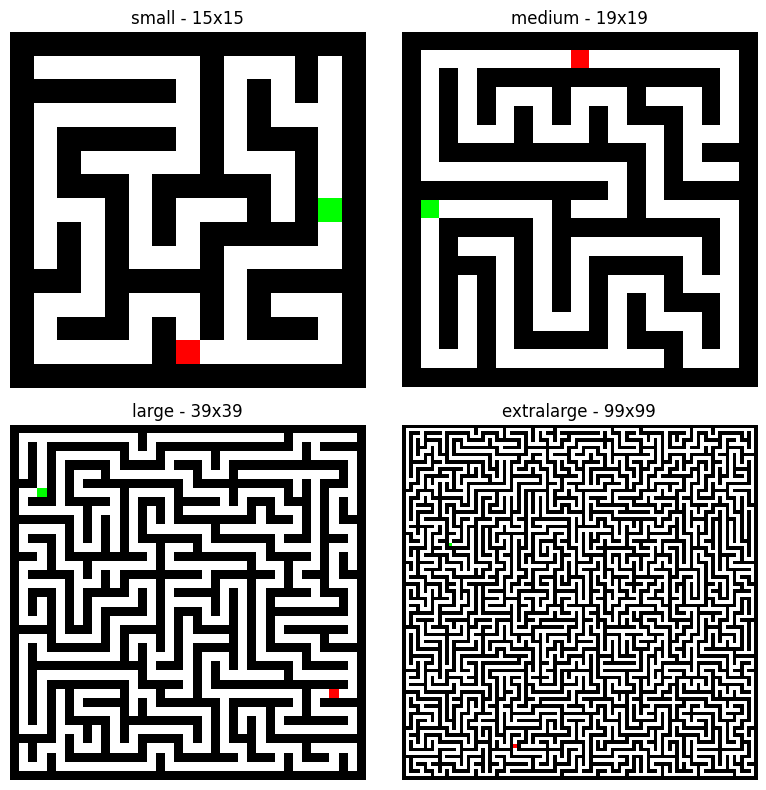

In [30]:
sizes = ["small", "medium", "large", "extralarge"]
datasets = {}

for size in sizes:
    repo_name = f"SakanaAI/mazes-{size}"
    datasets[size] = load_dataset(repo_name)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for idx, size in enumerate(sizes):
    
    # Get first example from train set
    example = datasets[size]['train'][0]
    image = example['image']  
    axes[idx].imshow(image)
        
    axes[idx].set_title(f"{size} - {image.size[0]}x{image.size[1]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig("maze_sizes_comparison.png", dpi=50, bbox_inches='tight')
plt.show()

Let's examine a maze dataset in more detail. First let's display a small maze.

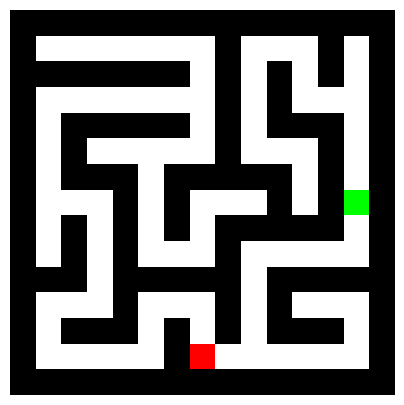

In [31]:
plt.figure(figsize=(5, 5))
plt.imshow(datasets["small"]["train"][0]["image"])
plt.axis('off')
plt.show()

Next let's display the solution path for this maze. We can see that the solution path is the actions required to traverse from the red pixel to the green pixel, padded by wait actions (W) to make all solution paths the same length.

In [54]:
DIRECTION_MAP = {
    0: "↑",
    1: "↓", 
    2: "←",
    3: "→",
    4: "W"
}
print(datasets["small"]["train"][0]["solution_path"])
print([DIRECTION_MAP[step] for step in datasets["small"]["train"][0]["solution_path"]])

[3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
['→', '→', '↑', '↑', '↑', '↑', '→', '→', '→', '→', '↑', '↑', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']


Now lets test the pretrained large maze solving CTM!

In [55]:
# Load the model
model = CTM.from_pretrained(f"SakanaAI/ctm-maze-large")
model = model.to(device)
model.eval();

Using neuron select type: first-last
Synch representation size action: 528
Synch representation size out: 2080


In [56]:
def collate_fn(batch):
    """Custom collate function for DataLoader"""
    images = []
    solutions = []
    
    for item in batch:
        # Convert image to tensor
        image_array = np.array(item['image']).astype(np.float32) / 255.0
        image_tensor = torch.from_numpy(image_array).permute(2, 0, 1)            
        images.append(image_tensor)
        solutions.append(torch.tensor(item['solution_path'], dtype=torch.long))
    
    images = torch.stack(images)
    solutions = torch.stack(solutions)
    
    return images, solutions

test_loader = DataLoader(
    datasets["large"]['test'],
    batch_size=64,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [57]:
def evaluate_batch(model, dataloader, device, max_batches=None):
    """Evaluate model on batches of data"""
    model.eval()
    
    all_targets = []
    all_predictions_most_certain = []
    all_losses = []

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(dataloader, desc="Evaluating")):
            if max_batches and batch_idx >= max_batches:
                break
                
            images = images.to(device)
            targets = targets.to(device)

            # Run inference
            predictions_raw, certainties, _ = model(images)
            predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 5, predictions_raw.size(-1))
            
            # Calculate loss and get most certain predictions
            loss, where_most_certain, _ = maze_loss(predictions, certainties, targets, use_most_certain=True)
            all_losses.append(loss.item())
            
            # Get predictions at most certain time step
            pred_at_certain = predictions.argmax(2)[
                torch.arange(predictions.size(0), device=predictions.device), 
                :, 
                where_most_certain
            ]
            
            all_targets.append(targets.cpu().numpy())
            all_predictions_most_certain.append(pred_at_certain.cpu().numpy())

        # Concatenate all batches
        all_targets = np.concatenate(all_targets)
        all_predictions_most_certain = np.concatenate(all_predictions_most_certain)
        
        # Calculate metrics
        step_accuracy = (all_targets == all_predictions_most_certain).mean()
        maze_solve_rate = (all_targets == all_predictions_most_certain).all(axis=1).mean()
        avg_loss = np.mean(all_losses)

    return step_accuracy, maze_solve_rate, avg_loss

In [58]:
step_accuracy, maze_solve_rate, avg_loss = evaluate_batch(model, test_loader, device, max_batches=20)


Evaluating:   1%|▏         | 1/79 [00:00<00:11,  6.94it/s]

Evaluating:  25%|██▌       | 20/79 [00:02<00:08,  6.90it/s]


In [59]:
print(f"Step Accuracy: {step_accuracy*100:.2f}%")
print(f"Maze Solve Rate: {maze_solve_rate*100:.2f}%")
print(f"Average Loss: {avg_loss:.4f}")

Step Accuracy: 99.45%
Maze Solve Rate: 95.31%
Average Loss: 0.0151


The model correctly predicted 99% of the steps through the mazes!

In [62]:
def create_maze_gif_visualization(model, testloader, device, log_dir):
    model.eval()
    with torch.no_grad():
        inputs_viz, targets_viz = next(iter(testloader))
        inputs_viz = inputs_viz.to(device)
        targets_viz = targets_viz.to(device)
        
        batch_index_to_viz = 1
        
        predictions_raw, certainties, _, pre_activations, post_activations, attention_tracking = model(inputs_viz, track=True)
        
        # Reshape predictions
        predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 5, predictions_raw.size(-1))
        
        # Reshape attention tracking for visualization
        att_shape = (model.kv_features.shape[2], model.kv_features.shape[3])
        attention_tracking = attention_tracking.reshape(attention_tracking.shape[0], attention_tracking.shape[1], -1, att_shape[0], att_shape[1])
        
        maze_input = inputs_viz[batch_index_to_viz].detach().cpu().numpy()
        
        maze_predictions = predictions[batch_index_to_viz].detach().cpu().numpy()
        maze_targets = targets_viz[batch_index_to_viz].detach().cpu().numpy()
        maze_attention = attention_tracking[:, batch_index_to_viz] if attention_tracking.ndim > 2 else attention_tracking

        # Generate the maze GIF - saves gif to log_dir/prediction.gif
        make_maze_gif(
            maze_input,
            maze_predictions,
            maze_targets,
            maze_attention,
            log_dir
        )


Processing frames for maze plotting:   0%|          | 0/75 [00:00<?, ?it/s]

Processing frames for maze plotting: 100%|██████████| 75/75 [00:12<00:00,  6.11it/s]



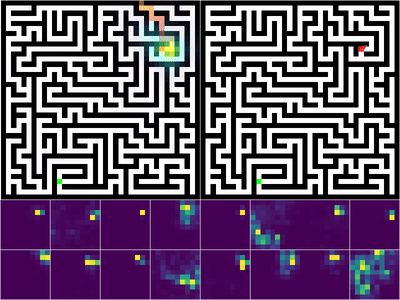

In [63]:
create_maze_gif_visualization(model, test_loader, device, "05_output")

reader = imageio.get_reader("05_output/prediction.gif")
frames = [reader.get_data(i) for i in range(min(len(reader), 100))]
mediapy.show_video(frames, width=400, codec="gif")